### Project AUEB Machine Learning and Computational Statistics
#### Mouselinos Spyridon 
##### February 2020
***

In [1]:
# Imports and Data Exploration

In [2]:
import scipy.io as sio
from sklearn.linear_model import Lasso
from scipy.optimize import minimize
from scipy.optimize import nnls 
import numpy as np
from numpy.linalg import pinv
import scipy.optimize 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

In [3]:
### Load Pavia Cube Data

In [4]:
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] 

In [5]:
### As mentioned we have a single Hyper Spectral Image of size 300x200 for 103 channels(L bands)
HSI.shape

(300, 200, 103)

In [6]:
### Load EndMembers Data

In [7]:
ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']

In [8]:
### We can see that for each L-Band we have 9 features
endmembers.shape

(103, 9)

In [9]:
### Let's create a translation list for the endmembers' id
endmembers_names = ["Water","Trees","Asphalt","Self-Blocking Bricks","Bitumen","Tiles","Shadows","Meadows","Bare Soil"]

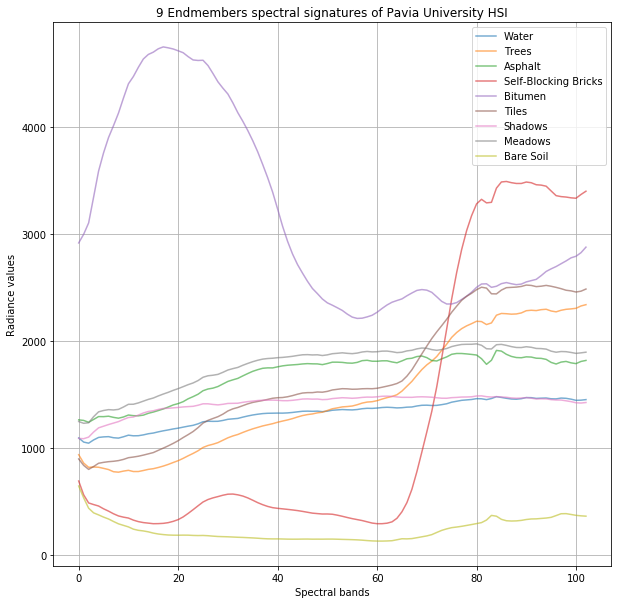

In [10]:
## Let's modify the plot function so it is more meaningful
fig = plt.figure(figsize=(10,10))
plt.grid()
for idx in range(endmembers.shape[1]):
    plt.plot(endmembers[:,idx], label=endmembers_names[idx], alpha=0.6)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.legend()
plt.show()

### Spectral Unmixing
***

In [11]:
# Perform unmixing for the pixels corresponding to nonzero labels
# Let's Load the corresponding Picture Mask
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

In [12]:
# As we can see it is the same size as our image, with 1 in the position where the unmixing should happen and 0 otherwise.
labels.shape

(300, 200)

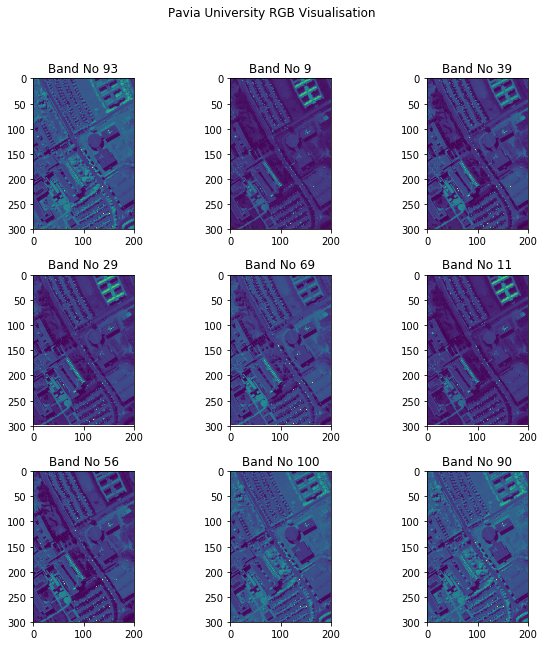

In [13]:
### Let's Visualize some random Bands for fun
fig, axs = plt.subplots(3, 3, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle('Pavia University RGB Visualisation') 
axs = axs.ravel()
for i,band in enumerate(np.random.choice(a=np.arange(0,HSI.shape[-1]), size=9, replace=False)):
    axs[i].imshow(HSI[:,:,band])
    axs[i].set_title('Band No {}'.format(band))
plt.show()
plt.close()

In [14]:
### In order to proceed we need to flatten-out the pixels into a single array of training examples, perform the same for the labels so we know what to unmix.
### Flatten Training Image.
HSI_flattened = HSI.reshape(-1,103)
Labels_flattened = labels.reshape(-1)
print("The Flattened HSI has shape:{}".format(HSI_flattened.shape))
print("The Flattened Labels have shape:{}".format(Labels_flattened.shape))

The Flattened HSI has shape:(60000, 103)
The Flattened Labels have shape:(60000,)


### Preliminaries
***
#### Here we will define our Estimators and Metrics that will be Used in the Method Section:
- I will use the LS estimator Class i have already made for the previous exersizes. It computes the LS estimation from matrix calculations as shown in class.
- I will a function that will perform the visual unmixing into the 9 abundance maps.
- I will create the MSE Reconstruction Statistic function.

In [15]:
class LSEstimator:
    def __init__(self, l2=0, extend_with_1=True):
        self.l2 = l2
        self.is_fit_ = False
        self.theta = None
        self.extend_with_1 = extend_with_1
        return
    
    def fit(self,X,y):
        train_points_len = len(X)
        label_points_len = len(y)
        assert train_points_len == label_points_len
        
        ### If the model needs to be extended with 1 do it
        if self.extend_with_1:
            ### Add leading '1' to the X's
            X = np.c_[np.ones(len(X)),X]
        else:
            ### Else build a model without Bias, e.g Keep X as it is
            pass
        

        ### Now let's calculate the X^T matrix
        XT = np.transpose(X)

        ### Now the X^T * X
        XTX = np.matmul(XT,X)
        
        ### Now let's add the regularization term
        XTXL2 = XTX + self.l2*np.identity(XTX.shape[0])

        ### Now the inverse of (XT * X) --> (XT *X)^(-1)
        invXTX = pinv(XTXL2)

        ### Now the Θ parameter vector can be given as
        theta = np.matmul(np.matmul(invXTX,XT),y)
        
        ### Raise fit flag 
        self.is_fit_ = True
        self.theta = theta
        return theta
    
    
    
    def predict(self,X, y_true=None):
        if not(self.is_fit_):
            raise ValueError("Fit Model On Data First!\n")
        else:
            if self.extend_with_1:
                ### Add leading '1' to the X's
                X = np.c_[np.ones(len(X)),X]
            else:
                ### Dont add leading '1', keep X as it is
                pass
            
            y_predicted = np.matmul(X,self.theta)
            mse = None
            if y_true is not None:
                error = y_true - y_predicted
                square_error = error*error
                mse = square_error.mean()
                
            return y_predicted, mse
        
    
    def fit_predict(self,X,y):
        self.fit(X=X,y=y)
        pred,mse = self.predict(X=X, y_true=y)
        return pred, mse
    
    
    def coeff(self):
        #Let's print the coefficients
        for idx, f in enumerate(self.theta):
            print("Theta_{} coefficient is {}".format(idx,f[0]))
        return

In [16]:
def plot_abundance_maps(a_map):
    """
        A function to Plot the Abundance Maps of the 9 EndMembers
    """
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle('Abundance Maps') 
    axs = axs.ravel()
    for i in range(9):
        axs[i].imshow(a_map[:,i].reshape((300,200)))
        axs[i].set_title('Endmember {}'.format(endmembers_names[i]))
    plt.show()
    plt.close()
    return

In [19]:
def calc_reconstruction_error(y_true, y_pred, mask, normalized=False):
    """
        A function to calculate the MSE of the reconstruction error, only on 
        the pixels shown by the mask.
    """
    assert y_true.shape[0] == y_pred.shape[0]
    assert y_pred.shape[0] == mask.shape[0]
    
    reconstruction_error = 0
    eligible_pixels = 0 
    for i in range(y_true.shape[0]):
        if mask[i] > 0:
            error = np.linalg.norm(y_true[i,:] - y_pred[i,:])**2
            if normalized:
                error /= np.linalg.norm(y_true[i,:])**2
            reconstruction_error += error
            eligible_pixels +=1
    mean_reconstruction_error =  reconstruction_error / eligible_pixels
    return mean_reconstruction_error

In [20]:
def compare_abundance_maps(a_map_array):
    """
        A function to Plot the per-Method Abundance Maps of the 9 EndMembers
    """
    fig, axs = plt.subplots(5, 9, figsize=(20, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    axs = axs.ravel()
    for a_idx, a_map in enumerate(a_map_array):
        for i in range(9):
            axs[a_idx*9 + i].imshow(a_map[:,i].reshape((300,200)))
            axs[a_idx*9 + i].set_title('{}'.format(endmembers_names[i]))
    plt.show()
    plt.close()
    return

### Methods
#### (A) Least Squares
***


In [21]:
### No - Bias Assumption
LS = LSEstimator(l2=0, extend_with_1=False)

### Result Matrix
abundance_array = np.empty((HSI_flattened.shape[0], 9))
predicted_array = np.empty((HSI_flattened.shape[0], HSI_flattened.shape[-1]))
### Iterate over every flattened pixel of our image
for pixel_id in range(0, HSI_flattened.shape[0]):
    ### Check if it is eligible
    if Labels_flattened[pixel_id] > 0:
        ### Use the 103 bands of the HSI image as target y
        y = HSI_flattened[pixel_id]
        ### Use the End Members as the X feature that needs to "predict" Y
        X = endmembers
        ### Use the LS Estimator above
        predicted_array[pixel_id] = LS.fit_predict(X=X, y=y)[0]
        ### Store the endmembers mixing coef
        abundance_array[pixel_id] = LS.theta

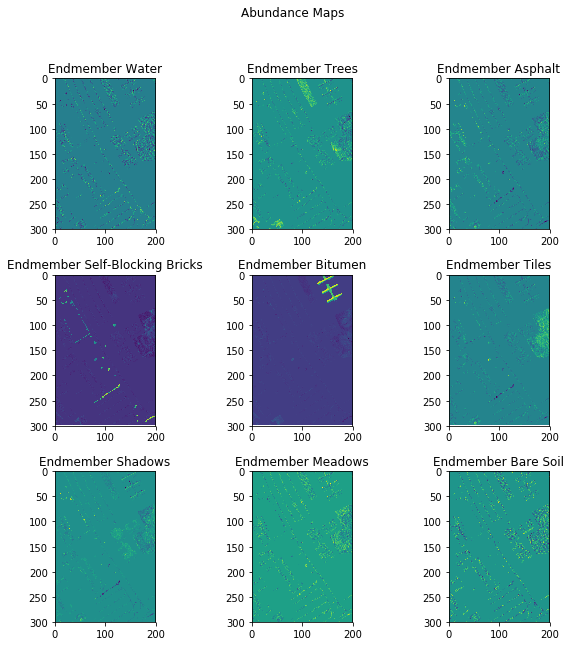

In [22]:
plot_abundance_maps(abundance_array)

In [23]:
reconstruction_error_1 = calc_reconstruction_error(y_true=HSI_flattened, y_pred=predicted_array, mask=Labels_flattened)
print(reconstruction_error_1)

118783.18062626594


In [24]:
abundace_array_LS = abundance_array

#### Important Note:
- For the Next methods i use the SLSQP and formulate the LS as a Constrained minimization Problem
- Theese Methods often require an initial guess, a good approximate would be to use the nnls solver to get a non-negative initial guess, or completely solve the problem.

### Methods
#### (B) Least squares imposing the sum-to-one constrain
***


In [25]:
def LS_sum_to_one_solver():
    ### Result Matrix
    abundance_array = np.empty((HSI_flattened.shape[0], 9))
    init_y = []
    # Initial Guess
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            init_y.append(HSI_flattened[pixel_id])
    
    init_y = np.array(init_y)
    initial_theta, _ = nnls(endmembers, init_y[np.random.randint(0,init_y.shape[0])])
    
    # Let's define the sum to one constraint on the theta coefficient vector 
    # Sum of theta = 1 => Sum of theta - 1 = 0
    cons = ({'type': 'eq', 'fun': lambda theta:  np.sum(theta)-1})
    # The main LS estimator is simply the multiplication of theta and data matrix in order to produce the prediction matrix
    # That gives us the minimization function
    def minimize_me(theta, X_matrix, Y_matrix):
        return np.linalg.norm(X_matrix.dot(theta) - Y_matrix)
    
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            y_ = HSI_flattened[pixel_id]
            X_ = endmembers
            output = minimize(minimize_me, initial_theta, args = (X_,y_), method = 'SLSQP', constraints = cons)
            abundance_array[pixel_id] = output.x
            
    predicted_array = endmembers.dot(abundance_array.T).transpose()
    return abundance_array, predicted_array

In [26]:
abundance_array, predicted_array = LS_sum_to_one_solver()

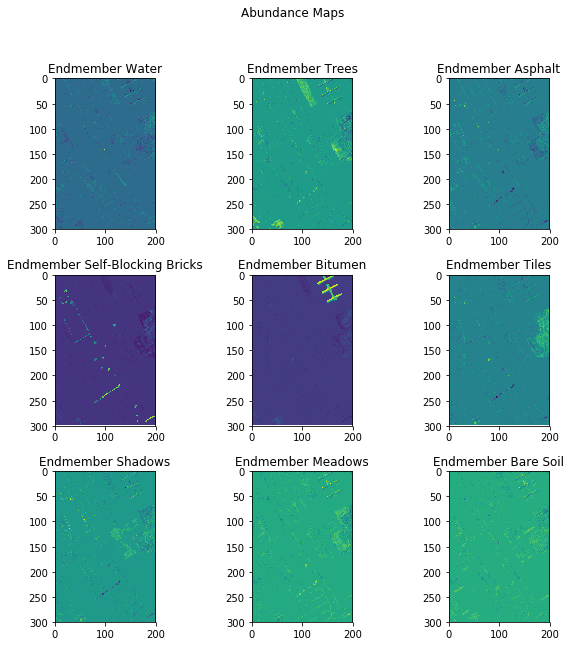

In [27]:
plot_abundance_maps(abundance_array)

In [28]:
reconstruction_error_2 = calc_reconstruction_error(y_true=HSI_flattened, y_pred=predicted_array, mask=Labels_flattened)
print(reconstruction_error_2)

160049.93080368053


In [29]:
abundance_array_LS_sum_to_one = abundance_array

### Methods
#### (C) Least squares imposing the non-negativity constraint on the entries of θ
***

In [30]:
### For this solution we can re-use the previous solver and just change the constraint

In [31]:
def LS_no_neg_solver():
    ### Result Matrix
    abundance_array = np.empty((HSI_flattened.shape[0], 9))
    init_y = []
    # Initial Guess
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            init_y.append(HSI_flattened[pixel_id])
    
    init_y = np.array(init_y)
    initial_theta, _ = nnls(endmembers, init_y[np.random.randint(0,init_y.shape[0])])
    
    # Let's define the non-negative constraint by bounding the theta values
    bnds = [(0., None) for t in initial_theta]
    
    # The main LS estimator is simply the multiplication of theta and data matrix in order to produce the prediction matrix
    # That gives us the minimization function
    def minimize_me(theta, X_matrix, Y_matrix):
        return np.linalg.norm(X_matrix.dot(theta) - Y_matrix)
    
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            y_ = HSI_flattened[pixel_id]
            X_ = endmembers
            output = minimize(minimize_me, initial_theta, args = (X_,y_), method = 'SLSQP', bounds=bnds)
            abundance_array[pixel_id] = output.x
            
    predicted_array = endmembers.dot(abundance_array.T).transpose()
    return abundance_array, predicted_array

In [32]:
abundance_array, predicted_array = LS_no_neg_solver()

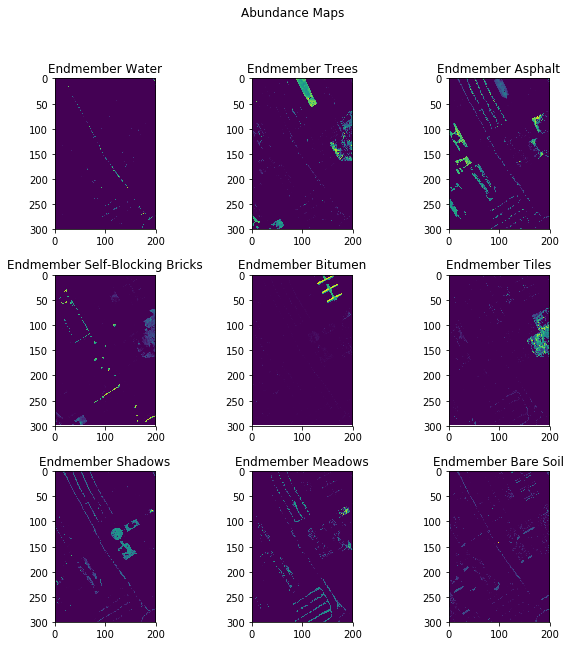

In [33]:
plot_abundance_maps(abundance_array)

In [34]:
reconstruction_error_3 = calc_reconstruction_error(y_true=HSI_flattened, y_pred=predicted_array, mask=Labels_flattened)
print(reconstruction_error_3)

569372.5190191144


In [35]:
abundance_array_LS_no_neg = abundance_array

### Methods
#### (D) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ
***

In [36]:
### For this solution we can re-use the previous solver and just add the extra constraint

In [37]:
def LS_no_neg_sum_to_one_solver():
    ### Result Matrix
    abundance_array = np.empty((HSI_flattened.shape[0], 9))
    init_y = []
    # Initial Guess
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            init_y.append(HSI_flattened[pixel_id])
    
    init_y = np.array(init_y)
    initial_theta, _ = nnls(endmembers, init_y[np.random.randint(0,init_y.shape[0])])
    
    # Let's define the non-negative constraint by bounding the theta values
    bnds = [(0., None) for t in initial_theta]
    cons = ({'type': 'eq', 'fun': lambda theta:  np.sum(theta)-1})
    # The main LS estimator is simply the multiplication of theta and data matrix in order to produce the prediction matrix
    # That gives us the minimization function
    def minimize_me(theta, X_matrix, Y_matrix):
        return np.linalg.norm(X_matrix.dot(theta) - Y_matrix)
    
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            y_ = HSI_flattened[pixel_id]
            X_ = endmembers
            output = minimize(minimize_me, initial_theta, args = (X_,y_), method = 'SLSQP', constraints=cons, bounds=bnds)
            abundance_array[pixel_id] = output.x
            
    predicted_array = endmembers.dot(abundance_array.T).transpose()
    return abundance_array, predicted_array

In [38]:
abundance_array, predicted_array = LS_no_neg_sum_to_one_solver()

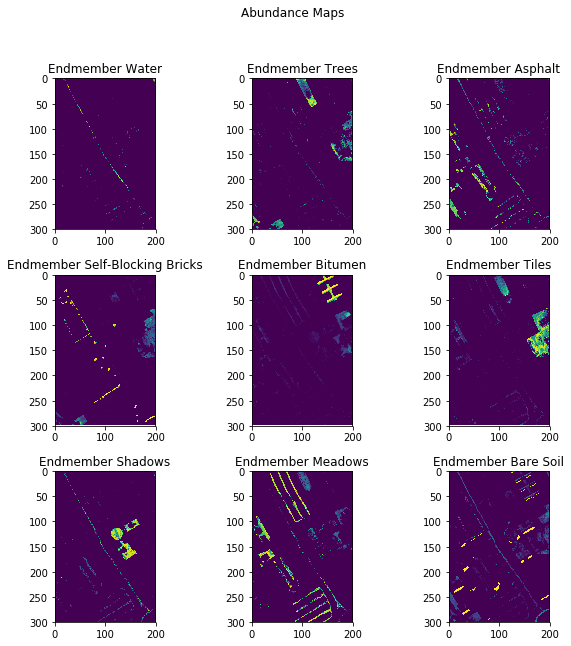

In [39]:
plot_abundance_maps(abundance_array)

In [40]:
reconstruction_error_4 = calc_reconstruction_error(y_true=HSI_flattened, y_pred=predicted_array, mask=Labels_flattened)
print(reconstruction_error_4)

4533681.706708095


In [41]:
abundance_array_LS_no_neg_sum_to_one = abundance_array

### Methods
#### (E) Lasso Regression Method
***

In [42]:
def Lasso_solver():
    solver = Lasso(alpha=0.05, positive =True, fit_intercept=False, max_iter = 1e7)
    
    ### Result Matrix
    abundance_array = np.empty((HSI_flattened.shape[0], 9))
    
    for pixel_id in range(0, HSI_flattened.shape[0]):
        if Labels_flattened[pixel_id] > 0:
            y_ = HSI_flattened[pixel_id]
            X_ = endmembers
            solver.fit(X_,y_)
            abundance_array[pixel_id] = solver.coef_
            
    predicted_array = endmembers.dot(abundance_array.T).transpose()
    return abundance_array, predicted_array

In [43]:
abundance_array, predicted_array = Lasso_solver()

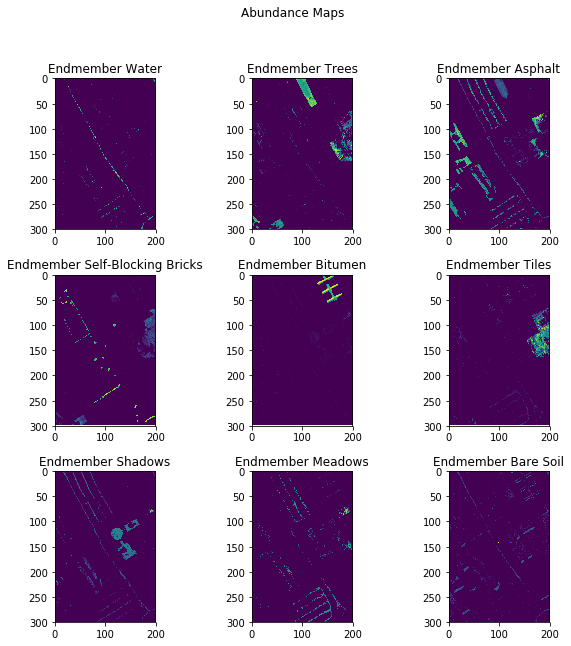

In [44]:
plot_abundance_maps(abundance_array)

In [45]:
reconstruction_error_5 = calc_reconstruction_error(y_true=HSI_flattened, y_pred=predicted_array, mask=Labels_flattened)
print(reconstruction_error_5)

570528.9442758941


In [46]:
abundance_array_Lasso = abundance_array

### Comparison of the spectral unmixing results
- Abundance Maps:
    * Row 1 corresponds to the LS method
    * Row 2 corresponds to the LS method with sum-to-one constraint
    * Row 3 corresponds to the LS method with non-negativity constraint
    * Row 4 corresponds to the LS method with both sum-to-one and non-negativity constraints
    * Row 5 corresponds to the LASSO method
***

In [47]:
abundance_maps = [abundace_array_LS, abundance_array_LS_sum_to_one, abundance_array_LS_no_neg, abundance_array_LS_no_neg_sum_to_one, abundance_array_Lasso]

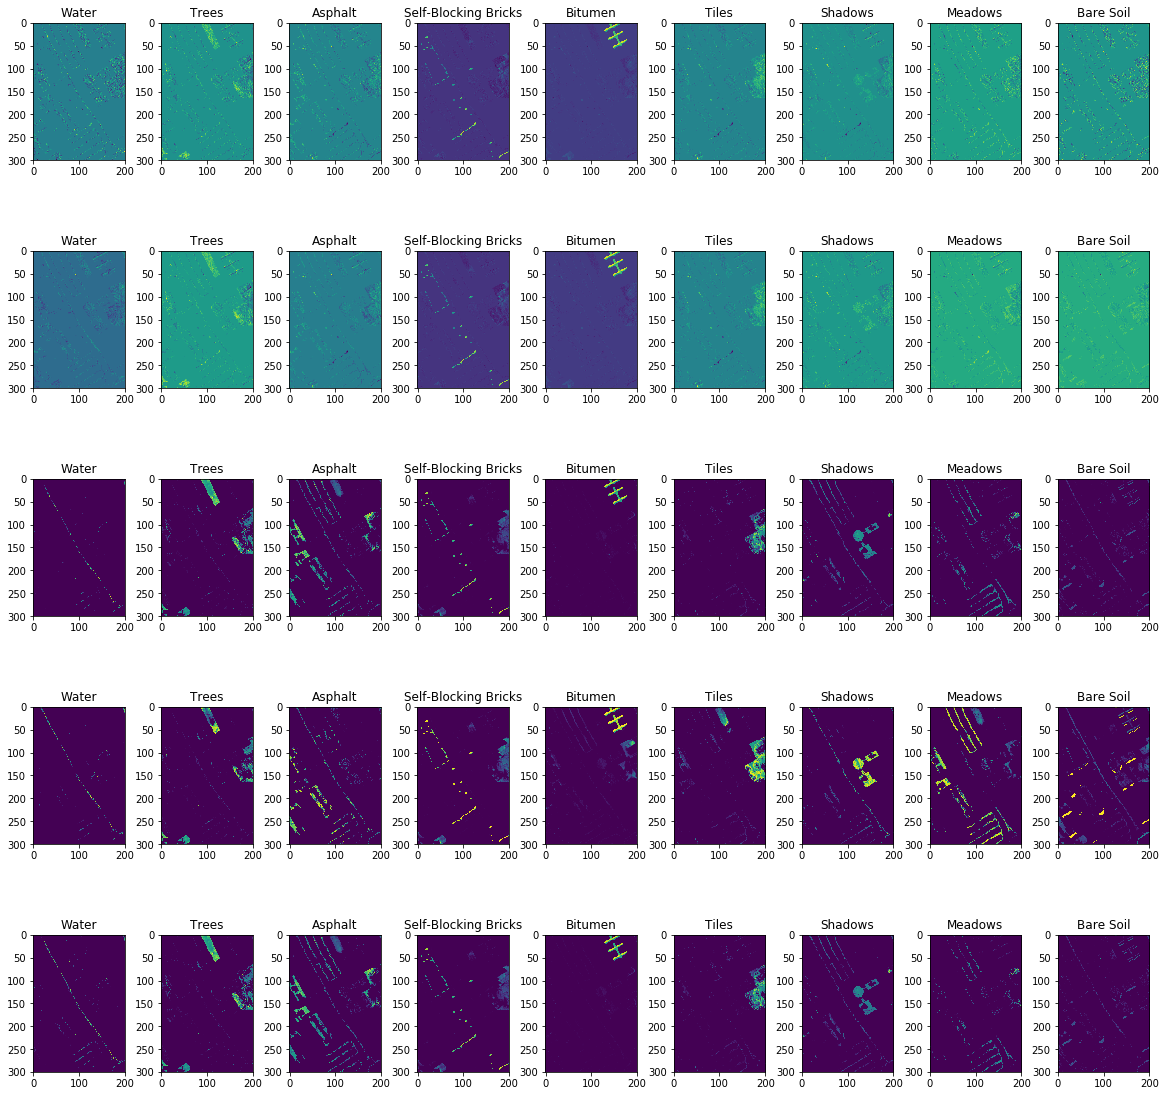

In [48]:
compare_abundance_maps(abundance_maps)

### The true class labels of the pixels of the Pavia University are depicted below
### The classes are not so clearly seperated from each other.
***

In [49]:
Pavia_truth = sio.loadmat('PaviaU_ground_truth.mat')

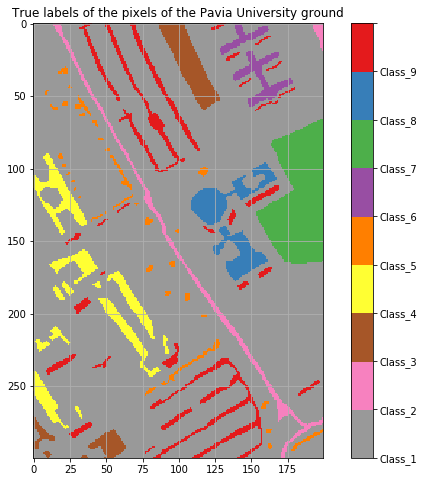

In [50]:
fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(Pavia_truth['y'], cmap='Set1_r')
ax.set_title('True labels of the pixels of the Pavia University ground')
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cbar.ax.set_yticklabels(['Class_{}'.format(f) for f in range(1,10)])
plt.grid()
plt.show()
plt.close()

The reconstruction errors for the methods used are:

In [51]:
print('The reconstruction error of LS is: {}'.format(round(reconstruction_error_1,5)))
print('The reconstruction error of LS with sum-to-one constraint is: {}'.format(round(reconstruction_error_2,5)))
print('The reconstruction error of LS with non-negativity constraint is: {}'.format(round(reconstruction_error_3,5)))
print('The reconstruction error of LS with both sum-to-one and non-negativity constraints is: {}'.format(round(reconstruction_error_4,5)))
print('The reconstruction error of LASSO is: {}'.format(round(reconstruction_error_5,5)))

The reconstruction error of LS is: 118783.18063
The reconstruction error of LS with sum-to-one constraint is: 160049.9308
The reconstruction error of LS with non-negativity constraint is: 569372.51902
The reconstruction error of LS with both sum-to-one and non-negativity constraints is: 4533681.70671
The reconstruction error of LASSO is: 570528.94428


#### Comments on the Unmixing Solution

An optimal spectral unmixing is expected to result in abundance maps where each one of them depicts only the pixels that correspond to the respective class with percentage of contribution equal to 1.

By comparing the class labels of the pixels with the abundance maps from the various methods implemented, it is observed that the overall performance of the LS method with both sum-to-one and non-negativity constraints is the best followed by the Lasso Solution.


Using as a performance criterion the reconstruction error one would conclude that LS method performance is the best. As can be seen, LS abundace maps are not in agreement with the true labels of the pixels. For  a lot of endemembers a high percentage contribution is found for pixels that do not belong to the respective class.

From the above it is concluded that the reconstruction error is not a reliable performance criterion. 


### Classification 
***

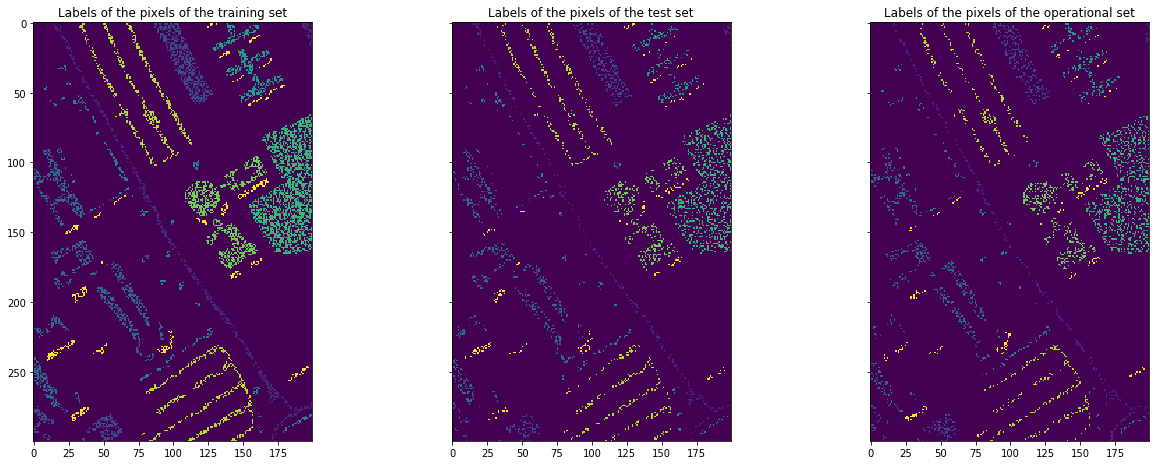

In [52]:
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')

# Trainining set for classification
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T

# Test set for classification 
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T

# Operational set for classification
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T


# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,20))
plt.subplots_adjust(wspace = 0.5)
ax1.imshow(Training_Set)
ax1.set_title('Labels of the pixels of the training set')
ax2.imshow(Test_Set)
ax2.set_title('Labels of the pixels of the test set')
ax3.imshow(Operational_Set)
ax3.set_title('Labels of the pixels of the operational set')
plt.show()

In [53]:
Training_Set_flat = Training_Set.reshape((60000,1))
Test_Set_flat = Test_Set.reshape((60000,1))
Operational_Set_flat = Operational_Set.reshape((60000,1))

In [54]:
### Let's make a function that can convert the Labels to a (X,Y) Dataset.
def make_dataset(original_image, class_annotation):
    ## Initialize the X,y slots for the data
    X = np.empty((0,103))
    y = np.empty((0,1))
    
    ## Iterate over the non-zero pixels denoted by the flag
    for i in range(class_annotation.shape[0]):
        if class_annotation[i] != 0:
            X = np.append(X, [original_image[i,:]], axis = 0) 
            y = np.append(y, [class_annotation[i]], axis = 0)
            
    return X,y

In [55]:
### Make Training Set
X_train, y_train = make_dataset(HSI_flattened, Training_Set_flat)

### Make Testing Set
X_test, y_test = make_dataset(HSI_flattened, Test_Set_flat)

### Make Operational Set
X_operational, y_operational = make_dataset(HSI_flattened, Operational_Set_flat)

The success_rate function is created that will be used throughout the second part of the project. 
* The success rate of a classifier is defined as the summation of the diagonal elements of the confusion matrix divided by the total number of elements of the matrix, N:
$$SR = \frac{1}{N}\sum_{i=1}^{M}A_{ii}$$


In [56]:
def success_rate(x):  
    success_rate = np.trace(x) / np.sum(x)
    return success_rate

### Method A)
###  Naive Bayes Classifier
#### Step 1) The naive Bayes classifer is trained based on the training data set performing 10-fold cross validation.
***

In [57]:
Bayes_Score = cross_val_score(GaussianNB(), X_train, y_train.ravel(), cv=10)
print("Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (Bayes_Score.mean(), Bayes_Score.std() * 2))

Bayes_Error = 1-Bayes_Score
print("Naive Bayes Error Mean %0.2f" % Bayes_Error.mean())
print("Naive Bayes Error Std %0.2f" % Bayes_Error.std())

Naive Bayes Accuracy: 0.64 (+/- 0.11)
Naive Bayes Error Mean 0.36
Naive Bayes Error Std 0.06


#### Step 2) The naive Bayes classifer is trained using the training data set and performance evaluation is performed based on the test data set.
***

In [58]:
clf = GaussianNB()
clf.fit(X_train, y_train.ravel())

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[131   0  37   0   0   0  80  13   0]
 [  0 326   4   6   0  17   0   0   0]
 [ 25   2 127   0   0  13  70 299   0]
 [  0   0   0 154   1   1   0   0   0]
 [  0   0   1   0 166   1   0   0   0]
 [  0 312   2  55  32 363   0   0   0]
 [ 18   0  26   0   0   0 277   0   0]
 [  2   1  67   0   0   1   2 388   0]
 [  0   0   0   2   0   0   0   0 185]]


In [59]:
# The naive Bayes success rate on test set is
success_rate(cm)

0.660118490801372

In [60]:
### Now Let's test on the Operational Set
predictions = clf.predict(X_operational)

cm = confusion_matrix(y_operational, predictions)
print("Confusion matrix:\n%s" % cm)
# The naive Bayes success rate on operational set is
success_rate(cm)

Confusion matrix:
[[154   0  46   1   0   0  57  14   0]
 [  0 304   3   6   0  13   0   0   0]
 [ 25   0 127   0   0  13  63 322   0]
 [  0   0   0 154   1   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0 333   5  51  35 342   0   0   0]
 [ 17   0  22   0   0   0 292   0   0]
 [ 10   8  82   0   1   0   5 339   0]
 [  0   0   0   1   0   0   0   0 188]]


0.6457748674773932

### Method B)
###  Minimum Eucledian Distance Classifier
#### Step 0) We need first to define it
***

In [61]:
class MEDC:
    """
        An Implementation of the Minimum Eucledian Distance Classifier
    """
    
    def __init__(self, n_classes=9):
        self.n_classes = n_classes
        self.is_fit_ = False
        self.class_means = np.empty((n_classes,103))
        return
    
    def fit(self, X, y):
        y = y.ravel()
        ### For every possible class
        for class_id in range(1, self.n_classes+1):
            x_slice = X[np.where(y==class_id)]
            class_mean = np.mean(x_slice, axis=0)
            self.class_means[class_id-1] = class_mean
            
        self.is_fit_ = True
        return
    
    def transform(self, X):
        if self.is_fit_:
            total_X = X
            results = np.empty(total_X.shape[0])
            for i, X in enumerate(total_X):
                canditate_class = 0
                canditate_dist = 1e10

                for idx, class_mean in enumerate(self.class_means):
                    dist_from_class = np.min(np.linalg.norm(X - class_mean)**2)
                    if dist_from_class < canditate_dist:
                        canditate_dist = dist_from_class
                        canditate_class = idx + 1
                results[i] = canditate_class
            return results
        else:
            print('Fit Estimator First!\n')
    
    
    def fit_transform(self,X,y):
        self.fit(X,y)
        cc = self.transform(X)
        return cc

#### Step 1) The min Euclidean distance classifier is trained based on the training data set performing 10-fold cross validation.
***

In [62]:
kfold = KFold(n_splits=10)
medc_score = np.empty(10)
index = 0
for train_index, test_index in kfold.split(X_train, y_train):
    clf = MEDC()
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    clf.fit(X_train_cv, y_train_cv)
    y_predicted = clf.transform(X_test_cv)
    pseudo_matrix = confusion_matrix(y_test_cv, y_predicted)
    medc_score[index] = success_rate(pseudo_matrix)
    index += 1

In [63]:
print("Min Eucledian Distance Classifier Accuracy: %0.2f (+/- %0.2f)" % (medc_score.mean(), medc_score.std() * 2))

medc_error = 1-medc_score
print("Min Eucledian Distance Classifier Error Mean %0.2f" % medc_error.mean())
print("Min Eucledian Distance Classifier Error Std %0.2f" % medc_error.std())

Min Eucledian Distance Classifier Accuracy: 0.53 (+/- 0.21)
Min Eucledian Distance Classifier Error Mean 0.47
Min Eucledian Distance Classifier Error Std 0.11


#### Step 2) The min Euclidean distance classifier is trained using the training data set and performance evaluation is performed based on the test data set.
***

In [64]:
clf = MEDC()
clf.fit(X_train,y_train)
y_predicted = clf.transform(X_test)
cm = confusion_matrix(y_test, y_predicted)

In [65]:
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[152   0  46   0   0   0  61   2   0]
 [  1 188   0   5   0 156   0   3   0]
 [ 66   2 198   0   0   1  39 230   0]
 [  0   0   0 154   0   0   0   0   2]
 [  0   0   0   0 128   0   0  40   0]
 [ 11 317   0  12  16 240   0 168   0]
 [ 61   0  23   0   0   0 237   0   0]
 [  2   1 145   0   0   1   7 305   0]
 [  0   0   0   0   0   0   0   0 187]]


In [66]:
# The Min Eucledian Distance Classifier success rate is
success_rate(cm)

0.5578422201434362

In [69]:
### Now Let's test on the Operational Set
predictions = clf.transform(X_operational)

cm = confusion_matrix(y_operational, predictions)
print("Confusion matrix:\n%s" % cm)
# The naive Bayes success rate on operational set is
success_rate(cm)

Confusion matrix:
[[177   0  49   0   0   0  44   2   0]
 [  2 183   0   4   0 135   0   2   0]
 [ 61   0 206   0   0   0  38 245   0]
 [  0   0   0 155   0   1   0   0   1]
 [  0   0   0   0 143   0   0  28   0]
 [  9 339   3   9  14 210   0 182   0]
 [ 62   0  18   0   0   0 251   0   0]
 [  5  11 149   0   0   0  13 267   0]
 [  0   0   0   0   0   0   0   0 189]]


0.5553476769566573

### Method C)
###  k-Nearest Neighbor Classifier
#### Step 1) The k-Nearest Neighbor Classifier is trained based on the training data set performing 10-fold cross validation.
***

In [70]:
kfold=10
## We choose n_neighbors equal to the number of classes we have
n_neighbors = 9
knc_score = cross_val_score(KNeighborsClassifier(n_neighbors=n_neighbors), X_train, y_train.ravel(), cv=kfold)

In [71]:
print("k-Nearest Neighbor Classifier Accuracy: %0.2f (+/- %0.2f)" % (knc_score.mean(), knc_score.std() * 2))

knc_error = 1-knc_score
print("Min Eucledian Distance Classifier Error Mean %0.2f" % knc_error.mean())
print("Min Eucledian Distance Classifier Error Std %0.2f" % knc_error.std())

k-Nearest Neighbor Classifier Accuracy: 0.85 (+/- 0.10)
Min Eucledian Distance Classifier Error Mean 0.15
Min Eucledian Distance Classifier Error Std 0.05


#### Step 2) The k-Nearest Neighbor Classifier is trained using the training data set and performance evaluation is performed based on the test data set.
***

In [72]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train.ravel())

y_predicted = clf.predict(X_test)

cm = confusion_matrix(y_test, y_predicted)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[195   0  15   0   0   0  24  27   0]
 [  0 322   0   0   0  31   0   0   0]
 [ 10   1 448   0   0   4   1  72   0]
 [  0   0   0 155   0   1   0   0   0]
 [  0   0   1   0 166   0   0   1   0]
 [  0  56   2   0   1 704   0   1   0]
 [ 12   0   5   0   0   0 303   1   0]
 [  9   2  85   0   0   0   2 363   0]
 [  0   0   0   0   0   0   0   0 187]]


In [73]:
# The k-Nearest Neighbor Classifier success rate is
success_rate(cm)

0.8864982850015591

In [74]:
### Now Let's test on the Operational Set
predictions = clf.predict(X_operational)

cm = confusion_matrix(y_operational, predictions)
print("Confusion matrix:\n%s" % cm)
# The naive Bayes success rate on operational set is
success_rate(cm)

Confusion matrix:
[[205   0  25   0   0   0  17  25   0]
 [  0 304   0   0   0  22   0   0   0]
 [ 16   3 451   0   0   1   4  75   0]
 [  0   0   0 155   0   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0  60   0   1   0 704   0   1   0]
 [ 12   0   4   0   0   0 315   0   0]
 [ 16   4  81   0   0   3   4 337   0]
 [  0   0   0   0   0   0   0   0 189]]


0.8827564702213907

### Method D)
###  Bayes Classifier
#### Step 1) The Bayes Classifier is trained based on the training data set performing 10-fold cross validation.
***

In [75]:
kfold=10
bayes_score = cross_val_score(QuadraticDiscriminantAnalysis(), X_train, y_train.ravel(), cv=kfold)

In [76]:
print("Bayes Classifier Accuracy: %0.2f (+/- %0.2f)" % (bayes_score.mean(), bayes_score.std() * 2))

bayes_error = 1-bayes_score
print("Bayes Classifier Error Mean %0.2f" % bayes_error.mean())
print("Bayes Classifier Error Std %0.2f" % bayes_error.std())

Bayes Classifier Accuracy: 0.86 (+/- 0.06)
Bayes Classifier Error Mean 0.14
Bayes Classifier Error Std 0.03


#### Step 2) The Bayes Classifier is trained using the training data set and performance evaluation is performed based on the test data set.
***

In [77]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train.ravel())

y_predicted = clf.predict(X_test)

cm = confusion_matrix(y_test, y_predicted)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[155   0  46   0   0   2  10  48   0]
 [  0 328   0   3   0  22   0   0   0]
 [ 10   1 430   0   0   0   0  95   0]
 [  0   0   0 154   0   2   0   0   0]
 [  0   0   0   0 168   0   0   0   0]
 [  0   1   0   1   0 762   0   0   0]
 [ 14   0  10   0   0   2 291   4   0]
 [ 19   0  73   0   0   2   0 367   0]
 [  3   0   0   1   2   0   0   0 181]]


In [78]:
# The Bayes Classifier success rate is
success_rate(cm)

0.8843155597131276

In [79]:
### Now Let's test on the Operational Set
predictions = clf.predict(X_operational)

cm = confusion_matrix(y_operational, predictions)
print("Confusion matrix:\n%s" % cm)
# The naive Bayes success rate on operational set is
success_rate(cm)

Confusion matrix:
[[165   0  44   0   0   3   6  54   0]
 [  0 314   0   1   0  11   0   0   0]
 [  8   0 461   0   0   0   0  81   0]
 [  0   0   0 156   0   1   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0   4   0   1   0 761   0   0   0]
 [ 21   0  18   0   0   1 285   6   0]
 [ 20   1  66   0   0  13   0 345   0]
 [  1   0   0   0   3   0   0   0 185]]


0.8864982850015591

#### Comments on Classification

For all classification Methods we applied the model both on the Test as well as Operational set. 
Our classifiers gave very close results meaning we did not sufffer from any overfitting bias, aw well as gave us a clear performance criterion on "unseen" data.


The Bayesian and KNN classifiers perform the best based on the success rate while the Naive Bayes follows and Euclidean classifier has the worst results.

From theory we know that in the former case that is strong evidence about the non-diagonality and non-independece of the covariance matrices in our inference.
The assumptions hold both in the Bayesian(Mahalanobis Distance Classification) and the KNN(That is an approximation of Bayes Classifier especially in the high n values).
The assumptions lead to fallacies in the Euclidean Distance Classification where diagonal matrices of same value are assumed as well as in the Naive Bayes Classification where diagonal matrices with different values are assumed. We can see better results in the Naive Bayes due to the fact that is more close to reality than the first.
Even better result is achieved under the more general assumptions. And thats the reasaon the Bayesian Method performs better.

## Part 3: Combination of results

From the spectral unmixing method we hope to get the abundance maps of the endmembers present in the image under the assumption of linear contribution.
A pixel can however consist of multiple endmembers and the major contribution of one will give the final class.Thus this problem is a percentage credit assignment to each pixel.

On the other hand classification assigns each pixel to a specific class given the frequency signature used as the input variable.

The endmember correspondance is not in accordance between evey endmember in both methods, that is expected given the fact that the linear assumption does not hold.

Ideally for each pixel, the endmember with maximun percentage of contribution (among the 9 endmembers)found by spectral unmixing should correspond to the respective class to which the pixel is assigned by classification. 

## Part 4: Neural Network for Classification

In [93]:
### For this part we will try a simple solution to create a feed-forward classifier
### We will need:
#### Tensorflow 2
#### Keras
#### Numpy

In [94]:
### Due to simplicity our model needs to have classes from 0 to 8
### Thats in order to use sparse_categorical_crossentropy

In [95]:
y_train = y_train.ravel() - 1
y_test = y_test.ravel() -1

In [96]:
### For better convergence the data need to be normalized in 0-1 for example
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_operational = X_operational/ X_operational.max()

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, PReLU, BatchNormalization, Dropout
from tensorflow.keras.models import load_model

In [98]:
### Let's define our network

In [99]:
model = Sequential()
model.add(Dense(100, input_shape=(103,), kernel_initializer='he_uniform'))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(100, kernel_initializer='he_uniform'))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(100, kernel_initializer='he_uniform'))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(units=9, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005 , decay=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Use early stopping to get the best model before overfitting
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Now fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[es, mc], batch_size=64)

InternalError: cudaGetDevice() failed. Status: cudaGetErrorString symbol not found.

In [ ]:
# load the saved model
saved_model = load_model('best_model.h5')

In [ ]:
# Make Predictions and Confusion Matrices on the Test and Operational Set

In [ ]:
y_operational_predicted = saved_model.predict(X_operational)
### Restore predictions back to 1-9 range
y_operational_predicted = np.argmax(y_operational_predicted, axis=1) + 1

cm = confusion_matrix(y_operational + 1, y_operational_predicted)
print("Test Confusion matrix:\n%s" % cm)

In [ ]:
# The FFN Classifier success rate is
success_rate(cm)